# <center> A doc2vec search engine to look over thousands of papers about Covid-19<center> 

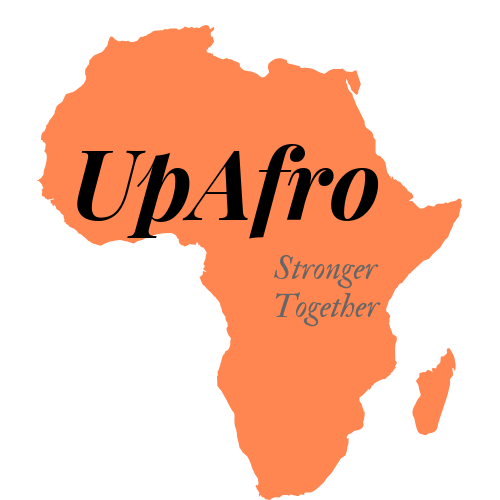

# <center> By [UpAfro](https://sites.google.com/view/upafro) <center> 

### <center> Team led by [Gilles HACHEME](https://fr.linkedin.com/in/gilles-q-hacheme-a0956ab7)<center>

### <center> Other team members :

### <center> [Nouréini SAYOUTI](https://www.linkedin.com/in/nour%C3%A9ini-sayouti-souleymane-20295aa9/?originalSubdomain=fr)  <center>

### <center> [Divine Tulomba](https://www.linkedin.com/in/divine-tulomba-912422189/)  <center>
    
### <center> [Gloria SOLOME](https://www.linkedin.com/in/sena-gloria-solome-789717159/)  <center>

# Why this notebook?

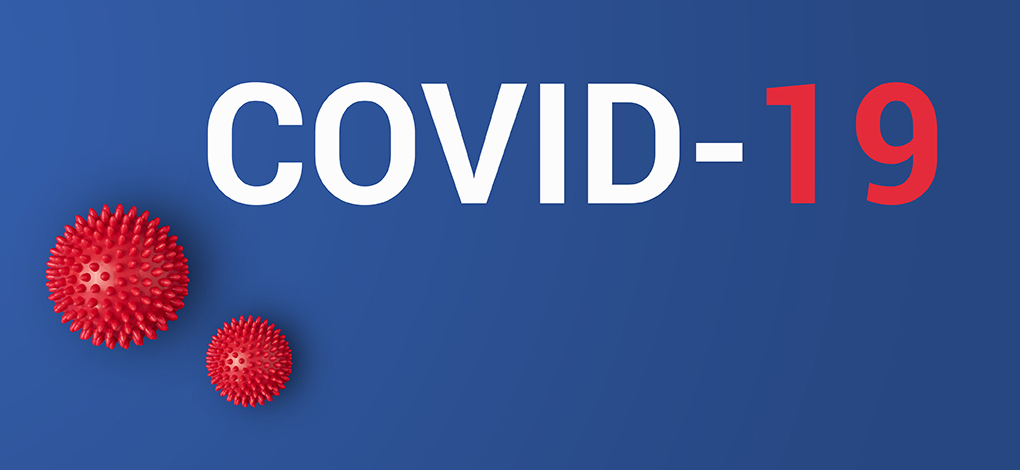

*Source: [Diabetesvoice](https://diabetesvoice.org/fr/nouvelles-en-bref/le-covid-19-et-le-diabete/)*

You are aware of the current health situation on our planet. The whole world is paralyzed by a respiratory virus called COVID-19, which is a new type of highly contagious coronavirus originating from Wuhan in Hubei Province, China. 

The objective of this notebook is to make a search engine to extract information from papers about this pandemic as simple as possible.  This tool allows bringing out summaries, relevant sentences and body texts of papers matching a search query and presenting the results in a user-friendly way. 

In order to do so, we first vectorize the papers using Doc2Vec techniques. We train the Doc2Vec model on almost 20.000 papers (title+abstract+body text). We are then able to find useful information about any search on Covid-19 in just in a few seconds. 


This work is done by a team of Data scientists settled by the association <a href='https://sites.google.com/view/upafro'> UpAfro </a>  to answer to the call of action from the <a href='https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge'> COVID-19 Open Research Dataset Challenge (CORD-19) </a>. 
This is our way to contribute to the fight against Covid-19.


# Search engine

Arguments to set: 

- search: string containing the search query
        
- pubdate_before: to get papers with publication dates before pubdate_before. format date : year-month-day
- pubdate_after: to get papers with publication dates after pubdate_before. format date : year-month-day
- pubdate_in: to get papers with publication dates between two dates. format date : year1-month1-day1 year2-month2-day2
- tags: string containing tag words
- topn: maximum number of results to be returned,
- topn_sent: maximum number of sentences closely linked to search in a given paper



To have an idea about what we are doing, here are some screenshots of what we get at the end of this notebook.

#### <center> Interactive search bar <center> 

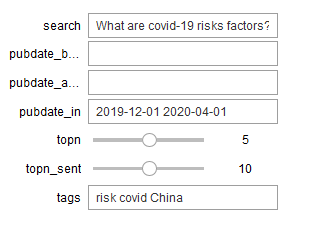

#### <center> Results <center> 

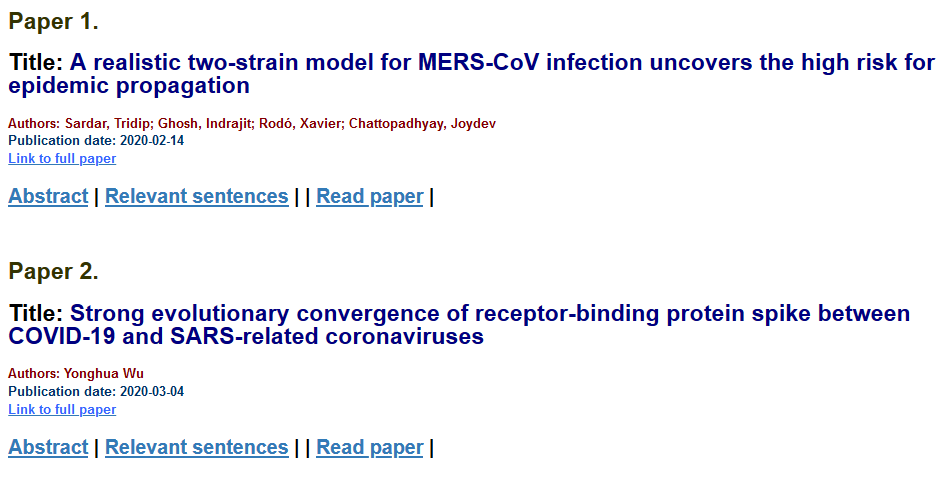

#### <center> Abstract from a paper in the results <center> 

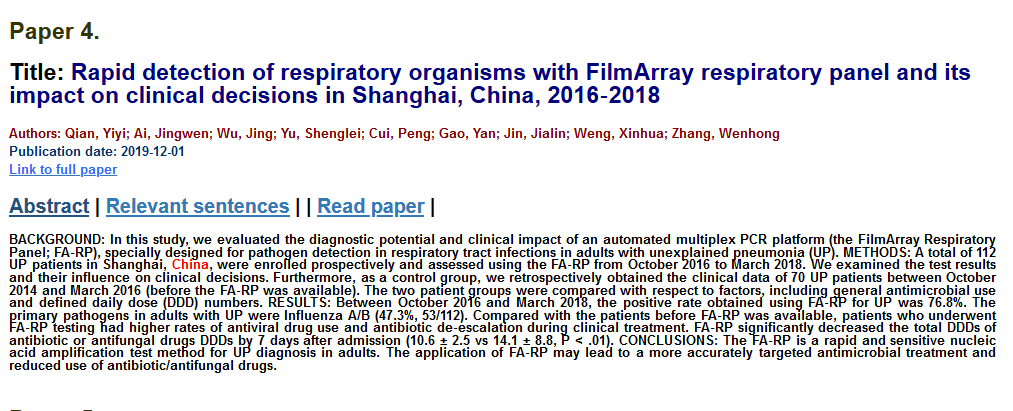

#### <center> Relevant sentences from a paper in the results <center>

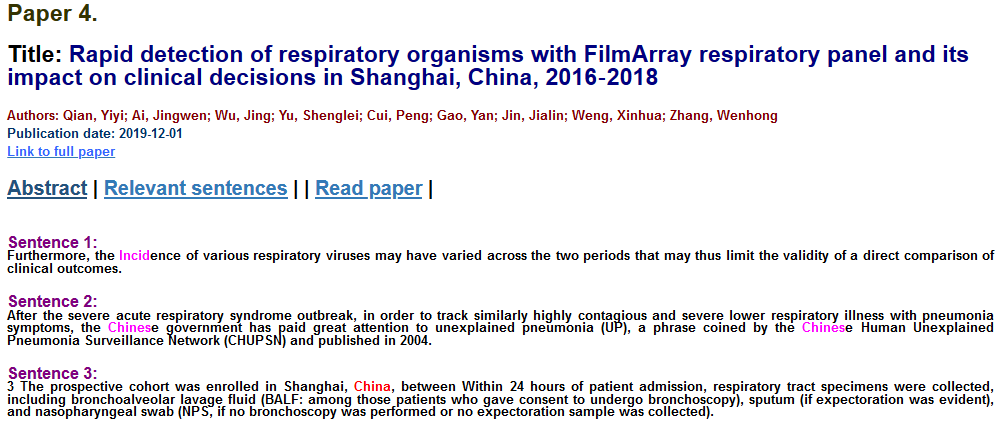

#### <center> Body text from a paper in the results <center>

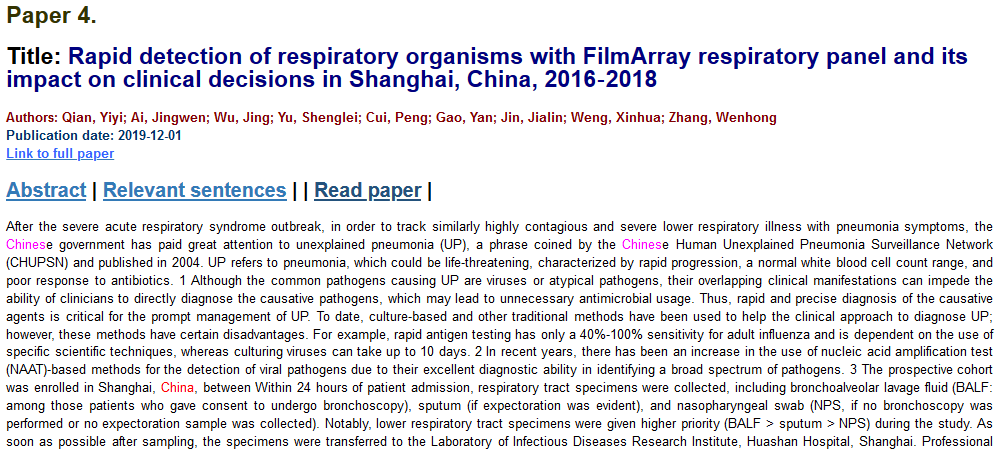

# Methodology



We want to build a search engine capable to take a request and find matching papers. We also look for most relevant sentences in the papers with regard to the request. 

Our methodology is simple. 

- We build a doc2vec model with papers dataset: doc2vec allows to vectorize documents.Vectors embed the meaning of documents and can be used for various tasks such as topic modelling. The doc2vec model built can also be used to infer new sentences. This feature will particularly be very useful for next steps. For more explanation about doc2vec, please take a look to at this tutorial: <a href='https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e'> Doc2vec </a>

- The doc2vec model is then used to vectorize every papers (we call paper a concatenation of title, abstract and body text) in our dataset and is also used to vectorize search requests. Then cosine similarity is used to find papers and sentences matching the query.

- We present results in a convenient way for user friendliness.


# Required packages

In [ ]:
import pandas as pd
import numpy as np


import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import preprocess_string

from ipywidgets import interact
from IPython.display import display, HTML

from gensim.summarization.textcleaner import get_sentences

import re
from sklearn.metrics.pairwise import cosine_similarity
import time


# Steps to build the search engine

## Data engineering

### Creating easy-to-use table from json files

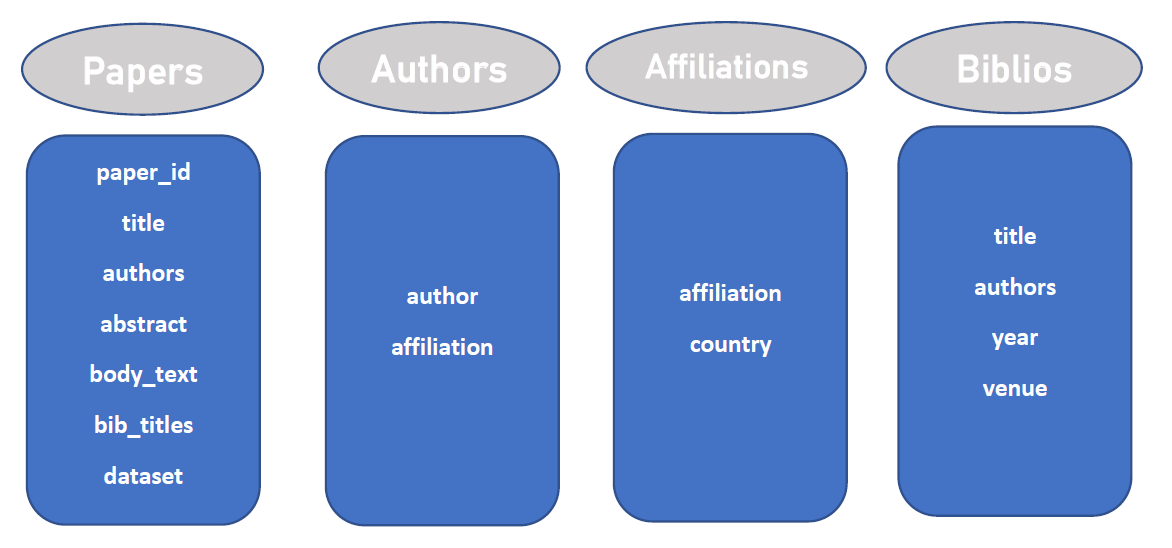

 <div align="justify"> 
    In this step we extract 4 different tables using the json files from repositories **biorxiv_medrxiv**, **comm_use_subset**, **noncomm_use_subset** and **custom_license**. 
But in this work we only use the table "papers", combined with the meta dataset. 
However, the remaining tables can be used to build a more advance searching engine. 
The task is performed by the following function that just need the directory path to extract the 4 tables. 
To be efficient in extracting information from thousands of json files, we recommend this function to be used in a parallelized framework. 
 </div> 

In [ ]:
def get_data(dir_path):
    
    """
    Take as input a directory path containing json files from 
    biorxiv_medrxiv, comm_use_subset, noncomm_use_subset or custom_license.
    Four dataframes are returned: papers_df, authors_df, affiliations_df, bib_entries_df
    """
    
    files = os.listdir(dir_path)
    papers_df = pd.DataFrame(columns= ["paper_id", "title", "authors", "abstract", "body_text", "bib_titles", "dataset"])
    authors_df = pd.DataFrame(columns= ["author", "affiliation"])
    affiliations_df = pd.DataFrame(columns= ["affiliation", "country"])
    bib_entries_df = pd.DataFrame(columns=["title", "authors", "year", "venue"])
    
    line_author_df = 0
    line_affiliations_df = 0
    line_bib_entries_df = 0
    
    
    
    for line,file in enumerate(files):
        
        #loading information
        n_files = len(files)
        if (line%300==0)or(line==n_files-1):
            print("Line", line, " ", round(100*line/n_files, 2),"%")
            
        file_path = os.path.join("../data/{}".format(dir),file)
    
        with open(file_path) as f:
            data = json.load(f)
        
        
        #Papers
        
        paper_id = data["paper_id"]
        
        title = data["metadata"]["title"]
        
        authors, affiliations, countries = "", "", ""
        for author in data["metadata"]["authors"]:
            first_last_name = author["first"] + " " + author["last"]
            authors = authors + " || " + first_last_name
            
            if author["affiliation"]=={}:
                affiliation = "NA"  #Non Available
                affiliations = affiliations + " || " + affiliation.strip()
                
                country = "NA"
                countries = countries + " || " + country.strip()
                continue
                
            affiliation = author["affiliation"]["laboratory"] + " " + author["affiliation"]["institution"]
            affiliations = affiliations + " || " + affiliation.strip()
            
            if "country" not in author["affiliation"]["location"].keys():
                country = "NA"
                countries = countries + " || " + country
                continue
            
            country = author["affiliation"]["location"]["country"]
            countries = countries + " || " + country
            
        authors = authors[4:]   #extracting out the first separator " || name1 || name2" => "name1 || name2"
        affiliations = affiliations[4:]
        countries = countries[4:]
        
        abstract = ""
        for info in data["abstract"]:
            abstract = abstract + " " + info["text"]
        abstract = abstract.strip()

        body_text = ""
        for info in data["body_text"]:
            body_text = body_text + " " + info["text"]
        body_text = body_text.strip()

        bib_titles, bib_authors, years, venues = "", "", "", ""
        for bib in data["bib_entries"]:
            bib_titles = bib_titles + " || " + data["bib_entries"][bib]["title"]
            
            
            year = data["bib_entries"][bib]["year"]
            
            years = years + " || " + str(year)
            
            venue = data["bib_entries"][bib]["venue"]
            venues = venues + " || " + venue
   
            bib_author = [author["first"] + " " + author["last"] for author in data["bib_entries"][bib]["authors"]]
            bib_author = " | ".join(bib_author)
            bib_authors = bib_authors + " || " + bib_author
            
        bib_titles, bib_authors, years, venues = bib_titles[4:] , bib_authors[4:], years[4:], venues[4:] 
        
        ##appending to paper_df
        papers_df.loc[line, :] = [paper_id, title, authors, abstract, body_text, bib_titles, dir]
        
        
        #Authors
        authors_list = authors.split(" || ")
        affiliations_list = affiliations.split(" || ")
        
        for i in range(len(authors_list)):
            authors_df.loc[line_author_df, :] = authors_list[i],  affiliations_list[i]
            
            line_author_df+=1
        
        #Affiliations
        countries_list = countries.split(" || ")
        
        for i in range(len(affiliations_list)):
            affiliations_df.loc[line_affiliations_df,:] = affiliations_list[i], countries_list[i]
            
            line_affiliations_df+=1
        
        
        #Bibliograpphy
        bib_titles_list = bib_titles.split(" || ")
        bib_authors_list = bib_authors.split(" || ")
        years_list = years.split(" || ")
        venues_list = venues.split(" || ")
        
        
        for i in range(len(bib_titles_list)):
            
            bib_entries_df.loc[line_bib_entries_df, :] = bib_titles_list[i], bib_authors_list[i], years_list[i], venues_list[i]
            line_bib_entries_df+=1
            
    authors_df = authors_df.drop_duplicates().reset_index(drop=True)
    affiliations_df = affiliations_df.drop_duplicates().reset_index(drop=True)
    bib_entries_df = bib_entries_df.drop_duplicates().reset_index(drop=True)
    
    return papers_df, authors_df, affiliations_df, bib_entries_df

### Loading papers data

We only load 100 papers to explain the different steps of our methodology. Of couse, results are poorer but it should be optimal for those who will run this notebook in order to have deeper insights of what is done around. At the end of the notebook, we make it simple to run every steps through the use of a *class*. For those who are unfamiliar with this notion, it is just a way to structure codes using  [object-oriented programming](https://en.wikipedia.org/wiki/Object-oriented_programming).

In [ ]:
df = pd.read_csv("/kaggle/input/papers/papers.csv", sep=";", nrows=100)
df.head()

In [ ]:
#dropping eventual duplicates
df = df.drop_duplicates()
df.shape

## Text engineering

### Keeping only papers with metadata

<div align="justify"> 
This step will enable to give more functionality to our search tool as we can have with meta data information such as : publication dates and url. 

We also notice that sometimes some information such as the asbtract can be missing in the papers table but present in the meta dataset. So we keep titles, abstracts and authors from the meta dataset.
</div> 

#### Loading the meta dataset

In [ ]:
meta_df = pd.read_csv("../input/CORD-19-research-challenge/metadata.csv")
meta_df.head()

#### Keeping only papers with meta information and transfering information from meta dataframe to papers dataframe

In [ ]:
#dropping any paper not present in the meta dataset. NB: paper_id (df) == sha (meta_df)
paper_in_meta = df.paper_id.isin(meta_df.sha)
df = df[paper_in_meta]
df = df.sort_values(by="paper_id", axis=0).reset_index(drop=True)

#Keeping meta data of papers present in the papers dataframe and sorting it acording to sha
meta_df = meta_df.loc[meta_df.sha.isin(df.paper_id.values)]
meta_df = meta_df.sort_values(by="sha", axis=0).reset_index(drop=True)

#We can now transfert information from meta to papers dataframe: both dataframe share now the same number of papers order in the same way
df["title"] = meta_df["title"]
df["abstract"] = meta_df["abstract"]
df["authors"] = meta_df["authors"]
df["publish_time"] = meta_df["publish_time"]
df["url"] = meta_df["url"]


From now on, we only use the papers dataframe.

#### Concatenating title, abstract and body_text

In [ ]:
df = df.loc[(df.title.notna()&df.authors.notna()&df.abstract.notna()), :].reset_index(drop=True)

df["paper"] = df.title + " " + df.abstract + " " + df.body_text


#### Cleaning and preprocessing (tokenization and filtering)

In [ ]:

df["paper_token"] = df.paper.apply(preprocess_string)

## Searching articles 

### Doc2Vec : Representing each paper in a 200 dimensional vector

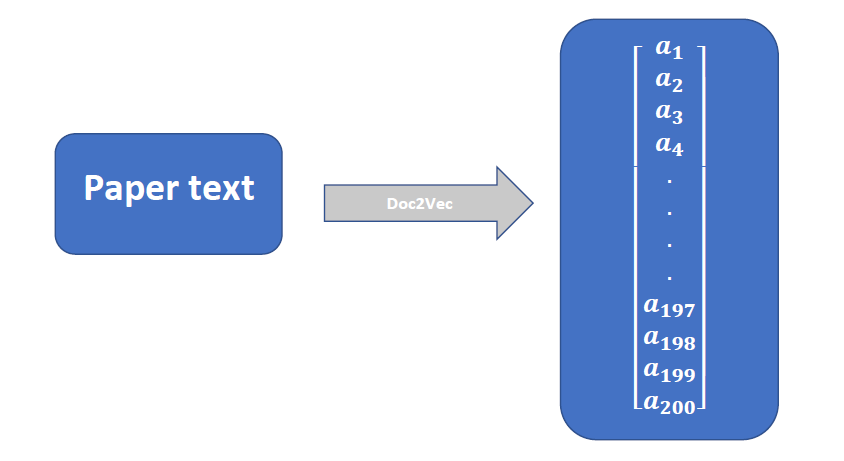

<div align="justify"> 
Here we vectorize papers with a Doc2Vec model named "Paragraph Vector-Distributed Memory" (PV-DM) as describe in the above image. Each paper is represented by a 200-dimensional vector that embed its meaning.  $a_i \space  
\forall \space i = 1,..., 200$, are real numbers and coordinates of the 200-dimensional vector. 

Here 200 is an arbitrary choice for the vector dimension. In general, higher the dimensionality, better it is, but of course at the cost of computational power. 

A nice tutorial about Doc2Vec models is given <a href=https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e> here.</a>.  
For technical details you can read this <a href=https://arxiv.org/pdf/1405.4053v2.pdf> article.</a>. 

</div> 

#### Preparing inputs to the doc2vec model


In [ ]:
n_papers = df.shape[0]
df["paper_tag"] = [TaggedDocument(words=df.paper_token[i],tags=[i]) for i in range(n_papers)]

#### Training and saving the doc2vec model


We have to mention that this training would be poor as we only use for this tutorial 100 papers to train the doc2vec model. More we have papers, better it should be. 

**NB**: The tool we propose at the end of this notebook is trained on almost 20.000 papers. 

In [ ]:
model_doc2vec = Doc2Vec(df.paper_tag.values, dm=1, vector_size=200, window=5, min_count=1, workers=8, epochs=5)


### Finding the n closest papers to a search

#### A function to detect tags in texts

We want to include an option in the search tool allowing to tag words and highlight them in red.

In [ ]:
def TagInText(text, tag_list):
    tagIn = False
    for tag in tag_list:
        match = re.match(".* {}.*|.* {}.*|.* {}.*".format(tag.lower(), tag.upper(), tag.capitalize()), text)
        if match:
            tagIn=True
    
    return tagIn

#### Training a Word2vec model to find lexicons of tags

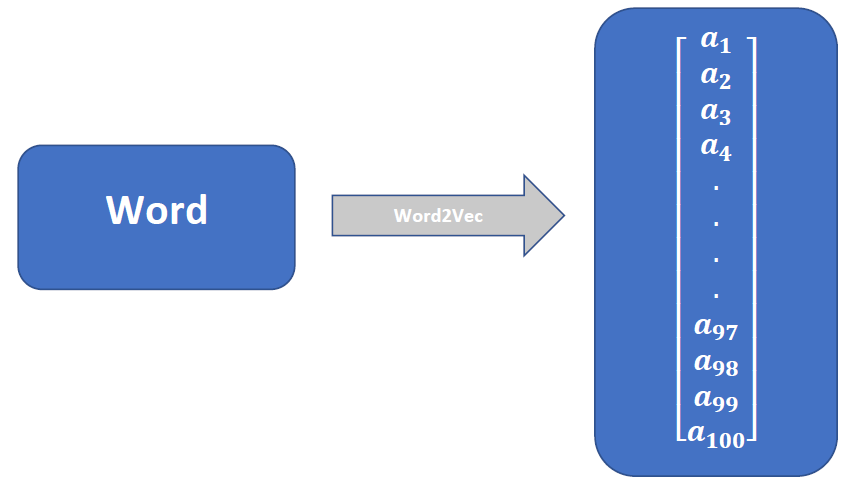

A problem with tagging is that several words can be used to search the same thing. 
Example: "population at risk" can also be search with "people at risk" or even "susceptible people". 
To account for that we build a [Word2Vec](https://en.wikipedia.org/wiki/Word2vec) model capable to find words used in similar contexts. Each word is vectorized in a 100 dimensional vector using [Continuous Bag of Words](https://towardsdatascience.com/nlp-101-word2vec-skip-gram-and-cbow-93512ee24314) (CBOW) a particular Word2Vec model. 100 is arbitrarily chosen, but it is generally enough to embed the meaning of words.

Similar words to tags will be highlighted with the <span style="color: #ff00ff;">magenta</span> color.


In [ ]:
model_word2vec = Word2Vec(sentences=df.paper_token, size=100,window=5,min_count=1, seed=1,  sg =0)

#model_word2vec.save("../data/embedding/final/word2vec_cbow.model")

In [ ]:

def SimilarWords(tags):
    tag_list = preprocess_string(tags)
    similar_words_list = []
    for tag in tag_list:
        #try is important here to avoid errors if a word is not in the vocabulary
        try:
            similar_words = model_word2vec.wv.most_similar(tag.lower())
            similar_words = [word_sim[0] for word_sim in similar_words]
            similar_words_list = similar_words_list + similar_words
        except:
            pass
    
    return list(set(similar_words_list)) #using set allows to filter out duplicates



In [ ]:
#example of words closed to China
tags = "China Wuhan"
SimilarWords(tags)

#### A function that find indexes of papers matching to the search

In [ ]:

def SearchIndex(search, data, column, model_doc2vec, pubdate_before=None, pubdate_after=None, pubdate_in=None, tags=None, topn=10, seed=0):
    
    """
    Take a search string and return list of line indexes of n closest papers
    
    search: string containing the query
    data: papers dataframe in the right format
    column: column in "data" containing papers texts
    model_doc2vec: a Doc2Vec model trained on papers from "data"
    pubdate_before: to get papers which publication dates are before "pubdate_before"; format date : year-month-day
    pubdate_after: to get papers which publication dates are after pubdate_before. format date : year-month-day
    pubdate_in: to get papers which publication dates are between date1 and date2. format date : year1-month1-day1 year2-month2-day2
    tags: string with tag words
    topn: maximum number of results to be returned,
    seed: an integer for random seed; useful for the doc2vec model. 
    """
    
    #filtering according to date
    if pubdate_before:
        data = data[data.publish_time<pubdate_before]
    if pubdate_after:
        data = data[data.publish_time>pubdate_after]
    if pubdate_in:
        date1 = pubdate_in.split()[0]
        date2 = pubdate_in.split()[1]
        data = data[(data.publish_time>=date1)&(data.publish_time<=date2)]
        
    n = data.shape[0]
    model_doc2vec.random.seed(seed)
    search = preprocess_string(search)
    search_vec = model_doc2vec.infer_vector(search)
    similar_text_index = model_doc2vec.docvecs.most_similar([search_vec], topn = n)
    similar_text_index = [index_sim[0] for index_sim in similar_text_index  if index_sim[0] in data.index]
    
    if tags: 
        tag_list = preprocess_string(tags)
        similar_words = SimilarWords(tags)
        tag_list = tag_list + similar_words
        
        filter_papers_index = []

        #finding articles containing tags
        tagged = data[column].apply(lambda paper: TagInText(paper,tag_list))
        tagged_papers_index = data[tagged].index
        
        similar_text_index = [index for index in similar_text_index if index in tagged_papers_index]

    
    similar_text_index = similar_text_index[:topn]

    
    
    return similar_text_index

#####  Example

In [ ]:
search = "What is covid-19 risks factors?"
tags = "risk covid China"

select_indexes = SearchIndex(search=search, data=df, column="paper", model_doc2vec=model_doc2vec, pubdate_before="2020-02-01", topn=5)
select_indexes

### For each relevant paper, find the top n sentences matching the search (in the body text)

#### Generating a dataframe for sentences

In [ ]:
sentences_df = pd.DataFrame(columns=["paper_index", "sentence"])

for paper_index in select_indexes:

    sentences_list = list(get_sentences(df.loc[paper_index, "body_text"]))
    n_sent = len(sentences_list)
    new_sent_df = pd.DataFrame(list(zip([paper_index]*n_sent, sentences_list)) , columns=["paper_index", "sentence"])
    sentences_df = sentences_df.append(new_sent_df)

sentences_df.head()

#### Sentences preprocessing

In [ ]:
#filtering out non relevant sentences 

pattern = ".*doi.*|.*http.*|.*copyright.*|.*author.*|.*license.*|.*without permission.*|.*CC-BY-NC-ND.*|.*author.*|.*funder.*|.*medrxiv.*|.*fig.*|.*all rights.*"
sentences_df["filtered"] = sentences_df["sentence"].apply(lambda sent: True if re.match(pattern, sent.lower()) else False)

sentences_df = sentences_df.loc[~sentences_df.filtered,:]
sentences_df = sentences_df.reset_index(drop=True)

sentences_df.head()

sentences_df["sentence_token"] = sentences_df.sentence.apply(preprocess_string)

#### Filtering out sentences with less than 5 tokens

sentences_df.sentence_token = sentences_df.sentence_token.apply(lambda sent: sent if len(sent)>5 else np.nan)
sentences_df = sentences_df.dropna().reset_index(drop=True)



#### A function to get relevant sentences

In [ ]:
def RelevantSent(search, papers_indexes, topn_sent=5, tags=None):
    """
    This is a function that look for more relevant sentences in a list of papers given a search.
    It returns a dictionary which keys are papers indexes and values are list of top n relevant sentences
    """
    model_doc2vec.random.seed(1)
    search = preprocess_string(search)
    search_vec = model_doc2vec.infer_vector(search)

    sentences_df["sent_vec"] = sentences_df.sentence_token.apply(model_doc2vec.infer_vector).values
    sentences_df["cos_similarity"] = sentences_df.sent_vec.apply(lambda sent_vec: cosine_similarity(search_vec.reshape(-1,1), sent_vec.reshape(-1,1))[0][0])

    topn_sent_dict = {}
    
    if tags:
        tags = preprocess_string(tags) + SimilarWords(tags)
            
    for paper_index in papers_indexes:
        sent_paper_order = sentences_df.loc[sentences_df.paper_index==paper_index, :]
        sent_paper_order = sent_paper_order.sort_values(by="cos_similarity", axis=0, ascending=False).reset_index(drop=True)

        
        #keeping only sentences with at least one tag word
        sent_list_tag = []
        if tags:
            sent_list = list(sent_paper_order.loc[:1000, "sentence"])
            for sent in sent_list:
                tagIn = TagInText(sent, tags)
                if tagIn is True:
                    sent_list_tag.append(sent)

        else:
            sent_list_tag = list(sent_paper_order.loc[:topn_sent-1, "sentence"])
            
        topn_sent_dict[paper_index] = sent_list_tag[:topn_sent]
        
    return topn_sent_dict

In [ ]:

top_sent = RelevantSent(search, select_indexes, topn_sent=10, tags=tags)
paper_index = select_indexes[0]
top_sent[paper_index]


It is possible to not get any relevant sentence cause we only keep the ones that contain at least one tag or one similar word. 

#### Presenting results

To present results in a simple and practical way, we make use of html power. 

In [ ]:

def SearchDisplayPaper(search, model_doc2vec, pubdate_before=None, pubdate_after=None, pubdate_in=None, topn=10, topn_sent=10, tags=None):
    """
    Take a request and return most relevant papers, with their titles, authors, abstracts and most relevant sentences
    
    search: string containing the query
    model_doc2vec: a Doc2Vec model trained on papers from "data"
    pubdate_before: to get papers which publication dates are before "pubdate_before"; format date : year-month-day
    pubdate_after: to get papers which publication dates are after pubdate_before. format date : year-month-day
    pubdate_in: to get papers which publication dates are between date1 and date2. format date : year1-month1-day1 year2-month2-day2
    tags: string with tag words
    topn: maximum number of results to be returned,
    seed: an integer for random seed; useful for the doc2vec model. 
    """
    
    select_indexes = SearchIndex(search=search, data=df, column="paper", model_doc2vec=model_doc2vec, pubdate_before=pubdate_before, pubdate_after=pubdate_after, pubdate_in=pubdate_in, tags=tags, topn=topn)
    top_sent = RelevantSent(search, select_indexes, topn_sent=topn_sent, tags=tags)

    if tags:
        tag_list = tags.split()
        similar_words = SimilarWords(tags)
            
    summary = ""
    
    for i,index in enumerate(select_indexes):
        title, authors, date, url, abstract = list(df.loc[index, ["title", "authors", "publish_time", "url", "abstract"]])
        
        sentences = top_sent[index]
        top_sentences = [
                """
                <p>&nbsp;</p>
                <h3 style="text-align: justify;"><span style="color: #800080;"><strong>Sentence {nb}:</h3>
                <h4 style="text-align: justify;"></strong> <span style="color: #000000;">{sent}</span></span></h4>
                """.format(nb=i+1, sent=sent) for i, sent in enumerate(sentences) 
                ]

        top_sentences = " ".join(top_sentences)
        
        
        if tags:
            
            #highlighting tags in magenta
            for tag in similar_words:
                abstract = re.sub(" {}| {}| {}".format(tag.lower(), tag.upper(), tag.capitalize()), """<span style="color: #ff00ff;"> {}</span>""".format(tag.capitalize()), abstract)
                top_sentences = re.sub(" {}| {}| {}".format(tag.lower(), tag.upper(), tag.capitalize()), """<span style="color: #ff00ff;"> {}</span>""".format(tag.capitalize()), top_sentences)
            #highlighting tags in red
            
            for tag in tag_list:
                abstract = re.sub(" {}| {}| {}".format(tag.lower(), tag.upper(), tag.capitalize()), """<span style="color: #ff0000;"> {}</span>""".format(tag.capitalize()), abstract)
                top_sentences = re.sub(" {}| {}| {}".format(tag.lower(), tag.upper(), tag.capitalize()), """<span style="color: #ff0000;"> {}</span>""".format(tag.capitalize()), top_sentences)
             
            
        summary = summary + """
        <p>&nbsp;</p>
        <p>&nbsp;</p>
        <h1><span style="color: #333300; background-color: #ffffff;">Paper {nb}.</span></h1>
        <p>&nbsp;</p>
        <h1><span style="color: #800000; background-color: #999999;">Title:<span style="background-color: #ffffff;"> {title} </span></span></h1>
        <p>&nbsp;</p>
        <p><strong><span style="color: #800000; background-color: #999999;"><span style="background-color: #ffffff;">Authors: {authors} </span></span></strong></p>
        <p><span style="color: #003366;"><strong>Publication date: {date} </strong></span></p>
        <p><a href={url} ><span style="color: #3366ff;"><strong>Link to full paper</strong></span> </a></p>
        <p>&nbsp;</p>
        <h2><span style="background-color: #999999;">Abstract: </span></h2>
        <p>&nbsp;</p>
        <h4  style="text-align: justify;"><span style="background-color: #ffffff;"> {abstract} </span></h4>
        
        """.format(nb=i+1, title=title, authors=authors, date=date, url=url, abstract=abstract)
        
        
        summary = summary + top_sentences
        
    summary = HTML(summary)
    
    return display(summary)

In [ ]:
SearchDisplayPaper(search, model_doc2vec=model_doc2vec, pubdate_before="2020-04-01", topn=10, topn_sent=5, tags=tags)

As you can notice, relevant sentences are not displayed in every results. The reason is we filter out every matched sentences without any tag or similar words. This is to increase relevance of displayed sentences.

You likely also noticed that some words are semi highlighted (in part). The reason is that in the data processing step, the preprocessing function **preprocess_string** that we used to tokenize papers' texts also includes a stemming function.

This is useful as using the steming of words allows including every word with the same stem. For instance, using the the stemming of **infection** that is **infect**, we implicity include at the same time **infection**, **infections**,  **infect**,  **infects**, **infected**.

# Creating a python class that integrates all the above steps (with some additional options)


Here we use the power of Object-Oriented Programming (OOP) in python to synthesize and structure in a proper way all the steps above. This also include the preprocessing steps. But to be efficient, we create an option to directly pass preprocessed data to the class so that we can save lots of time. We add the option of reading the body text if available and a click to show/hide option to read abstracts, relevant sentences and body texts in a convenient way.
With tags highlighting, it is easy to keep track of the essential parts of papers relevant for the search. 

If you did not run the previous data processing steps, the doc2vec and word2vec model building, and you want to do it in one line, just instantiate the class in the following way: **searching = Search(papers_df, meta_df)**.

**papers_df** and **meta_df** are respectively papers and meta dataframes.

Once the processing is done, save the processed data and the doc2vec model. You can retrieve them using the Search object:

- processed papers : **searching.papers_df**    (saving example: **searching.papers_df.to_csv(path)** )
- doc2vec model built with papers : **searching.model_doc2vec** (saving example: **searching.model_doc2vec.save(path)** )
- word2vec model built with papers : **searching.model_word2vec** (saving example: **searching.model_word2vec.save(path)** )

If you already got preprocessed papers and the related doc2vec and word2vec models, you can directly go to next Section 
    
##### NB: Do not forget to import packages at section "Required packages" and run next cell to create the Search class. 

In [ ]:
class Search():
    def __init__(self, papers_df, meta_df=None, papers_preprocessed=False, model_doc2vec=None, model_word2vec=None):
        """
         papers_df: papers dataframe in the right fromat
         meta_df: meta dataframe. if "papers_preprocessed=True", meta_df must be provided
         papers_preprocessed: True if papers need to be preprocessed, False otherwise
         model_doc2vec: A doc2vec model train on papers from "papers_df["paper"]"
         model_word2vec: A word3vec model preferably trained on "papers_df["paper"]"
        """
        
        if papers_preprocessed:
            self.papers_df = papers_df
            self.model_doc2vec = model_doc2vec 
            self.model_word2vec = model_word2vec
        else:   
            self.papers_df = self.preprocessing_papers(papers_df, meta_df)
        
             
        
            
        self.html_index = 0  #for html hidden links
        
    def preprocessing_papers(self, papers_df, meta_df):

        print("Processing papers!", time.strftime("%H:%M:%S", time.localtime()))

        
        print("Keeping only papers with meta data!", time.strftime("%H:%M:%S", time.localtime()))

        paper_in_meta = papers_df.paper_id.isin(meta_df.sha)
        papers_df = papers_df[paper_in_meta]
        papers_df = papers_df.sort_values(by="paper_id", axis=0).reset_index(drop=True)

        ##Keeping meta data of papers present in the papers dataframe and sorting it acording to sha/paper_id
        meta_df = meta_df.loc[meta_df.sha.isin(papers_df.paper_id.values)]
        meta_df = meta_df.sort_values(by="sha", axis=0).reset_index(drop=True)

        ##We can now transfert information from meta to papers dataframe
        papers_df["title"] = meta_df["title"]
        papers_df["abstract"] = meta_df["abstract"]
        papers_df["authors"] = meta_df["authors"]
        papers_df["publish_time"] = meta_df["publish_time"]
        papers_df["url"] = meta_df["url"]
        
        print("Concatenation of titles, abstracts and body_texts!", time.strftime("%H:%M:%S", time.localtime()))
        papers_df["paper"] = papers_df.title + " " + papers_df.abstract + " " + papers_df.body_text
        
        
        print("Dropping papers without title, authors names or abstract!", time.strftime("%H:%M:%S", time.localtime()))
        papers_df = papers_df.loc[(papers_df.title.notna()&papers_df.authors.notna()&papers_df.abstract.notna()), :].reset_index(drop=True)
        
        print("Tokenization!", time.strftime("%H:%M:%S", time.localtime()))
        papers_df["paper_token"] = papers_df.paper.apply(preprocess_string)
        

        print("Building a Doc2Vec model with preprocessed data", time.strftime("%H:%M:%S", time.localtime()))
        n_papers = papers_df.shape[0]
        papers_df["paper_tag"] = [TaggedDocument(words=papers_df.paper_token[i],tags=[i]) for i in range(n_papers)]
        model_doc2vec = Doc2Vec(papers_df.paper_tag.values, dm=1, vector_size=200, window=5, min_count=1, workers=8, epochs=5)
        self.model_doc2vec = model_doc2vec 
        
        print("Building a Word2Vec model with preprocessed data", time.strftime("%H:%M:%S", time.localtime()))
        model_word2vec = Word2Vec(sentences=papers_df.paper_token, size=100,window=5,min_count=1, seed=1,  sg =0)
        self.model_word2vec = model_word2vec 

        print("Processing over! Do not forget saving the preprocessed data (self.papers_df), the doc2vec and word2vec models (self.model_doc2vec and self.model_word2vec) to go faster next time")

        return papers_df
    
    
        
    def preprocessing_sentences(self, select_indexes):
        
        """
        Generating a dataframe with columns ["paper_index", "sentence"]: 
        each line with a given sentence and the paper_index of the paper containing the sentence
        """
        sentences_df = pd.DataFrame(columns=["paper_index", "sentence"])

        for paper_index in select_indexes:

            sentences_list = list(get_sentences(self.papers_df.loc[paper_index, "body_text"]))
            n_sent = len(sentences_list)
            new_sent_df = pd.DataFrame(list(zip([paper_index]*n_sent, sentences_list)) , columns=["paper_index", "sentence"])
            sentences_df = sentences_df.append(new_sent_df)

    
        #filtering out non relevant sentences 

        pattern = ".*doi.*|.*http.*|.*copyright.*|.*author.*|.*license.*|.*without permission.*|.*CC-BY-NC-ND.*|.*author.*|.*funder.*|.*medrxiv.*|.*fig.*|.*all rights.*"
        sentences_df["filtered"] = sentences_df["sentence"].apply(lambda sent: True if re.match(pattern, sent.lower()) else False)

        sentences_df = sentences_df.loc[~sentences_df.filtered,:]

        sentences_df["sentence_token"] = sentences_df.sentence.apply(preprocess_string)

        #### Filtering out sentences with less than 5 tokens

        sentences_df.sentence_token = sentences_df.sentence_token.apply(lambda sent: sent if len(sent)>5 else np.nan)
        sentences_df = sentences_df.dropna().reset_index(drop=True)
        
        return sentences_df
    
    
    def TagInText(self, text, tag_list):
        tagIn = False
        for tag in tag_list:
            match = re.match(".* {}.*|.* {}.*|.* {}.*".format(tag.lower(), tag.upper(), tag.capitalize()), text)
            if match:
                tagIn=True

        return tagIn
    
    def SimilarWords(self,tags):
        """
        Find 5 words similar to each tag. Return a list of words filtered out of duplicates.
        """
        tag_list = preprocess_string(tags)
        similar_words_list = []
        for tag in tag_list:
            #try is important here to avoid errors if a word is not in the vocabulary
            try:
                similar_words = model_word2vec.wv.most_similar(tag.lower())
                similar_words = [word_sim[0] for word_sim in similar_words]
                similar_words_list = similar_words_list + similar_words
            except:
                pass

        return list(set(similar_words_list)) #using set allows to filter out duplicates


    def RelevantSent(self, search, papers_indexes, topn_sent, tags=None):
        """
        This is a function that look for more relevant sentences in a list of papers given a search.
        It returns a dictionary which keys are papers indexes and values are list of top n relevant sentences
        """
        
        sentences_df = self.preprocessing_sentences(papers_indexes)
        model_doc2vec = self.model_doc2vec
        
        model_doc2vec.random.seed(1)
        search = preprocess_string(search)
        search_vec = model_doc2vec.infer_vector(search)

        sentences_df["sent_vec"] = sentences_df.sentence_token.apply(model_doc2vec.infer_vector).values
        sentences_df["cos_similarity"] = sentences_df.sent_vec.apply(lambda sent_vec: cosine_similarity(search_vec.reshape(-1,1), sent_vec.reshape(-1,1))[0][0])

        topn_sent_dict = {}
        
        if tags:
            tag_list = preprocess_string(tags) + self.similar_words #including similar words to tags
            
        for paper_index in papers_indexes:
            sent_paper_order = sentences_df.loc[sentences_df.paper_index==paper_index, :]
            sent_paper_order = sent_paper_order.sort_values(by="cos_similarity", axis=0, ascending=False).reset_index(drop=True)


            #keeping only sentences with at least one tag word
            sent_list_tag = []
            if tags:
                sent_list = list(sent_paper_order.loc[:1000, "sentence"])
                for sent in sent_list:
                    tagIn = self.TagInText(sent, tag_list)
                    if tagIn:
                        sent_list_tag.append(sent)

            else:
                sent_list_tag = list(sent_paper_order.loc[:topn_sent-1, "sentence"])

            topn_sent_dict[paper_index] = sent_list_tag[:topn_sent]
        

        return topn_sent_dict

        
    
    def SearchIndex(self, search, pubdate_before=None, pubdate_after=None, pubdate_in=None, tags=None, topn=10, seed=0):

        """
        Take a search string and return list of indexes of n closest papers

        search: string containing the query
        pubdate_before: to get papers which publication dates are before "pubdate_before"; format date : year-month-day
        pubdate_after: to get papers which publication dates are after pubdate_before. format date : year-month-day
        pubdate_in: to get papers which publication dates are between date1 and date2. format date : year1-month1-day1 year2-month2-day2
        tags: string with tag words
        topn: maximum number of results to be returned,
        seed: an integer for random seed; useful for the doc2vec model. 
        """
        data = self.papers_df
        model_doc2vec=self.model_doc2vec
        
        #filtering according to date
        if pubdate_before:
            data = data[data.publish_time<pubdate_before]
        if pubdate_after:
            data = data[data.publish_time>pubdate_after]
        if pubdate_in:
            date1 = pubdate_in.split()[0]
            date2 = pubdate_in.split()[1]
            data = data[(data.publish_time>=date1)&(data.publish_time<=date2)]
            
        #Ranging papers indexes according to their similarity to the search query
        n = data.shape[0]
        model_doc2vec.random.seed(seed)
        search = preprocess_string(search)
        search_vec = self.model_doc2vec.infer_vector(search)
        similar_text_index = self.model_doc2vec.docvecs.most_similar([search_vec], topn = n)
        similar_text_index = [index_sim[0] for index_sim in similar_text_index  if index_sim[0] in data.index]
        
        if tags:
            tag_list = tags.split()
            self.similar_words = self.SimilarWords(tags)
            tag_list = tag_list + self.similar_words
            
            filter_papers_index = []

            #finding articles containing tags
            
            tagged = data["paper"].apply(lambda paper: self.TagInText(paper,tag_list))
            tagged_papers_index = data[tagged].index

            similar_text_index = [index for index in similar_text_index if index in tagged_papers_index]

        similar_text_index = similar_text_index[:topn]

        return similar_text_index


    def SearchDisplayPaper(self, search, pubdate_before=None, pubdate_after=None, pubdate_in=None, topn=10, topn_sent=5, tags=None):
        """
        Take a request and return most relevant papers, with their titles, authors, abstracts and most relevant sentences

        search: string containing the request
        pubdate_before: Publication dates should be before pubdate_before. format date : year-month-day
        pubdate_after: Publication dates should be after pubdate_before. format date : year-month-day
        pubdate_in: Publication dates should be between pubdate_before. format date : year1-month1-day1 format date year2-month2-day2
        tags: string with tag words
        topn: maximum number of results to be returned,
        topn_sent: maximum number of sentences closely linked to search in a given paper
        seed: an integer for random seed
        """
        
         
        select_indexes = self.SearchIndex(search=search, pubdate_before=pubdate_before, pubdate_after=pubdate_after, pubdate_in=pubdate_in, tags=tags, topn=topn)
        top_sent = self.RelevantSent(search, select_indexes, topn_sent=topn_sent, tags=tags)

        
    
        summary = """
                <script>
                function visibilite(thingId)
                {
                var targetElement;
                targetElement = document.getElementById(thingId) ;
                if (targetElement.style.display == "none")
                {
                targetElement.style.display = "" ;
                } else {
                targetElement.style.display = "none" ;
                }
                }
                </script>
                </body>
                """
        if tags!=None:   
            tag_list = preprocess_string(tags)
            
        paper_df = self.papers_df
        
        for i,index in enumerate(select_indexes):
            title, authors, date, url, abstract, body_text = list(paper_df.loc[index, ["title", "authors", "publish_time", "url", "abstract", "body_text"]])
            sentences = top_sent[index]
            #adding relevant sentences from the paper
            top_sentences = [
                """
                <p>&nbsp;</p>
                <h3 style="text-align: justify;"><span style="color: #800080;"><strong>Sentence {nb}:</h3>
                <h4 style="text-align: justify;"></strong> <span style="color: #000000;">{sent}</span></span></h4>
                """.format(nb=i+1, sent=sent) for i, sent in enumerate(sentences) 
                ]

            top_sentences = " ".join(top_sentences)
            
            
            if tags!=None:
                
                #highlighting similar words to tags in magenta color
                for tag in self.similar_words:
                    abstract = re.sub(" {}| {}| {}".format(tag.lower(), tag.upper(), tag.capitalize()), """<span style="color: #ff00ff;"> {}</span>""".format(tag.capitalize()), abstract)
                    top_sentences = re.sub(" {}| {}| {}".format(tag.lower(), tag.upper(), tag.capitalize()), """<span style="color: #ff00ff;"> {}</span>""".format(tag.capitalize()), top_sentences)
                    body_text = re.sub(" {}| {}| {}".format(tag.lower(), tag.upper(), tag.capitalize()), """<span style="color: #ff00ff;"> {}</span>""".format(tag.capitalize()), body_text)
            
                #highlighting tags in red color
                for tag in tag_list:
                    abstract = re.sub(" {}| {}| {}".format(tag.lower(), tag.upper(), tag.capitalize()), """<span style="color: #ff0000;"> {}</span>""".format(tag.capitalize()), abstract)
                    top_sentences = re.sub(" {}| {}| {}".format(tag.lower(), tag.upper(), tag.capitalize()), """<span style="color: #ff0000;"> {}</span>""".format(tag.capitalize()), top_sentences)
                    body_text = re.sub(" {}| {}| {}".format(tag.lower(), tag.upper(), tag.capitalize()), """<span style="color: #ff0000;"> {}</span>""".format(tag.capitalize()), body_text)
                
                
            #adding paper's summary
            summary = summary + """
            <p>&nbsp;</p>
            <p>&nbsp;</p>
            <h1><span style="color: #333300; background-color: #ffffff;">Paper {nb}.</span></h1>
            <p>&nbsp;</p>
            <h1><span style="color: #000000";>Title:<span style="color: #000080;"> {title} </span></span></h1>
            <p>&nbsp;</p>
            <p><strong><span style="color: #800000; background-color: #999999;"><span style="background-color: #ffffff;">Authors: {authors} </span></span></strong></p>
            <p><span style="color: #003366;"><strong>Publication date: {date} </strong></span></p>
            <p><a href={url} ><span style="color: #3366ff;"><strong>Link to full paper</strong></span> </a></p>
            <p>&nbsp;</p>
            <h2>
                <a href="javascript:visibilite('divid1{html_id}');"><span style="background-color: ##ffffff;">Abstract</span></a>
                | <a href="javascript:visibilite('divid2{html_id}');"><span style="background-color: ##ffffff;">Relevant sentences</span></a> |
                | <a href="javascript:visibilite('divid3{html_id}');"><span style="background-color: ##ffffff;">Read paper</span></a> |          
            </h2>
            <p>&nbsp;</p>
            <div id="divid1{html_id}" style="display:none;"></p>
                <h4  style="text-align: justify;">{abstract}</strong></h4>
            </div>
            <div id="divid2{html_id}" style="display:none;"></p>
                <p  style="text-align: justify;">{top_sentences}</strong></p>
            </div>
            <div id="divid3{html_id}" style="display:none;"></p>
                <p  style="text-align: justify;">{body_text}</strong></p>
            </div>
            """.format(nb=i+1, html_id=self.html_index, title=title, authors=authors, date=date, url=url, abstract=abstract, top_sentences=top_sentences, body_text=body_text)
            
            self.html_index+=1 
            
            
            
        summary = HTML(summary)
    
        return display(summary)
    
    
    


# Answering to questions

Here we focus on one particular task: **What do we know about COVID-19 risk factors?**.

- Data on potential **risks factors** : 
    - **Smoking**, pre-existing **pulmonary disease**
    - **Co-infections** (determine whether co-existing **respiratory/viral infections** make the virus more **transmissible** or **virulent**) and other **co-morbidities**
    - **Neonates** and **pregnant** women
    - **Socio-economic** and **behavioral factors** to understand the **economic impact** of the virus and whether there were differences.

- **Transmission dynamics** of the virus, including the basic **reproductive number**, **incubation period**, **serial interval**, **modes of transmission** and **environmental factors**

- **Severity of disease**, including **risk of fatality** among **symptomatic hospitalized patients**, and **high-risk patient** groups

- **Susceptibility** of populations

- Public health **mitigation measures** that could be effective for control

But of course, our tool is applicable to any task of the  <a href =https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/tasks> CORD-19 tasks.</a>

#### Loading the complete papers and meta datasets, doc2vec, and word2vec models

We have to mention that the doc2vec and word2vec models have been trained on the complete papers dataset. 
Here is the preprocessing step (screenshot):

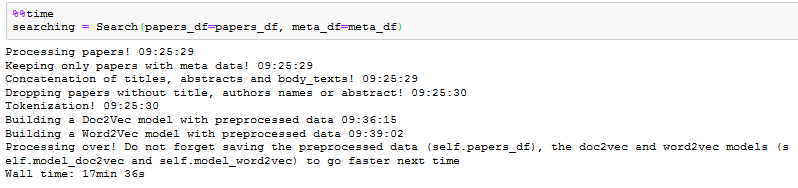

Here is how to save the generated objects:

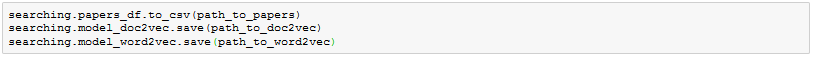

In the screenshot, the preprocessed papers dataframe is saved in csv format. But for efficiency, we strongly recommend formats such as [pickle](https://ianlondon.github.io/blog/pickling-basics/).

From now, we will no longer need this step of preprocessing before instantiating the **Search** class.

In the next cell code, we import the objects that have been generated in the preprocessing step.

In [ ]:
papers_preprocessed_df = pd.read_pickle("../input/preprocessedcord-19/papers_preprocessed.pkl") 
meta_df = pd.read_csv("../input/CORD-19-research-challenge/metadata.csv")
model_doc2vec =  Doc2Vec.load("../input/preprocessedcord-19/doc2vec_model_tag_papers")
model_word2vec =  Word2Vec.load("../input/preprocessedcord-19/word2vec_cbow.model")

In [ ]:
#papers are preprocessed 
papers_preprocessed_df.head()

#### Instantiating the Search class

In [ ]:
%%time
searching = Search(papers_df=papers_preprocessed_df, papers_preprocessed=True,
                   model_doc2vec = model_doc2vec)


## Q1: Risks factors

In [ ]:
search_risk = "What are covid-19 risk factors?"
tags_risk = """risk smoking pulmonary disease co-infection respiratory viral infection 
transmissible virulent co-morbidities co-morbidity Neonate pregnant Socio-economic behavior economic impact"""

searching.SearchDisplayPaper(search=search_risk, pubdate_in="2019-12-01 2020-04-01", topn=5, topn_sent=10, tags=tags_risk)

## Q2: Transmission dynamics

In [ ]:
search_transmission = """"Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors"""
tags_transmission = """transmission dynamics reproductive incubation serial interval environmental"""

searching.SearchDisplayPaper(search=search_transmission,  pubdate_in="2019-12-01 2020-04-01", topn=5,  topn_sent=10, tags=tags_transmission)

## Q3: Severity of disease

In [ ]:
search_severity = """Severity of disease including risk of fatality 
among symptomatic hospitalized patients and high-risk patient groups about covid-19"""

tags_severity  = """severity disease fatality symptomatic hospitalized high-risk"""

searching.SearchDisplayPaper(search=search_severity, pubdate_in="2019-12-01 2020-04-01", topn=5, topn_sent=10, tags=tags_severity)

## Q4: Susceptibility of populations

In [ ]:
search_susceptibility = """Susceptibility of populations"""

tags_susceptibility  = """susceptibility population"""

searching.SearchDisplayPaper(search=search_susceptibility, pubdate_in="2019-12-01 2020-04-01", topn=5, topn_sent=10, tags=tags_susceptibility)

## Q5: Public health mitigation measures

In [ ]:
search_mitigation = """Public health mitigation measures"""

tags_mitigation  = """public health mitigation measures government"""

searching.SearchDisplayPaper(search=search_mitigation, pubdate_in="2019-12-01 2020-04-01", topn=5, topn_sent=10, tags=tags_mitigation)

# A simple widget for searching

If you are not data scientist or simply do not have time to dive into the codes above, this tool is for you. You can simply write down your search question with related parameters and you will get below the result to your request. 

##### NB: You need to import packages at section "Required packages" and run the code cell at section "Creating a python class..." to create the Search class. 

Arguments to settle: 

- search: string containing the search query
        
- pubdate_before: to get papers with publication dates before pubdate_before. format date : year-month-day
- pubdate_after: to get papers with publication dates after pubdate_before. format date : year-month-day
- pubdate_in: to get papers with publication dates between two dates. format date : year1-month1-day1 year2-month2-day2
- tags: string containing tag words
- topn: maximum number of results to be returned,
- topn_sent: maximum number of sentences closely linked to search in a given paper

In [ ]:
interact(searching.SearchDisplayPaper, search="What are covid-19 risks factors?", 
         pubdate_before="", pubdate_after="", pubdate_in="2019-12-01 2020-04-01",
         topn=5, topn_sent=10, tags="risk covid China")

# Practical utility and Limits of our tool

##  Practical utility

Our search tool can be very useful for health scientists, research centers and more generally to the medical community to deal with the massive flow of information. 

With this tool the community is able to have papers matching any search about Covid-19 and a concrete summary. 

The search tool we built is done almost from scratch. We make this choice rather than using pretrained search tools as we want it to really be specific to Covid-19 litterature.We also wanted to avoid as much as possible the *black-box* side of some pre-existing packages while keeping it as simple as possible. 
However, this tool can be used in other contexts: 
- for instance to answer to all the tasks at <a href =https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/tasks> CORD-19 tasks,</a>
- or to have summary about other litteratures whether in the health field or beyond as far as data of the same format can be provided.  

With the interactive tool that we built, no need to be expert in data science to use it. 
While with the Python class that we built, we make it simple to integrate this tool in any web or mobile applications. 

## Limits of our tool

Due to our computational power limits we only use about 20.000 papers to learn 200 dimensional vectors to represent papers for our doc2vec search engine. Though this gives pretty good results, we know that with more papers and higher vector dimensionality, the results should even be better. 

So, we strongly recommend to the research community to use more papers, and higher dimensionnality to improve the results from this search engine. 

Due to incomplete access to the "body text" of some papers, some results could be cut. 

# To conclude

We hope that this work will be helpful for the medical community and we are completly openned to suggestions to upgrade this work. Be free to get in touch with us. 

This work is powered by [UpAfro](https://sites.google.com/view/upafro), a Pan-African association based in Marseille, France.  